# Zonal statistics

A typical interaction between raster and vector data is zonal statistics - an aggregation of values of the raster that belong of a geographical region defined by a geometry. Vector data cubes are an ideal data structure for such a use case as they preserve the structure of the original cube and all its attributes while allowing you to index it by a polygon or linestring geometry. The geometry can represent any arbitrary geometry within the bounds of the original raster.

In [9]:
import geodatasets
import geopandas as gpd
import numpy as np
import rioxarray
import xarray as xr
import xproj

import xvec

The example using the ERA-Interim reanalysis, monthly averages of upper level data:

In [10]:
ds = xr.tutorial.open_dataset("eraint_uvz")
ds

/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'z' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'u' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'v' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 17MB
Dimensions:    (longitude: 480, latitude: 241, level: 3, month: 2)
Coordinates:
  * longitude  (longitude) float32 2kB -180.0 -179.2 -178.5 ... 178.5 179.2
  * latitude   (latitude) float32 964B 90.0 89.25 88.5 ... -88.5 -89.25 -90.0
  * level      (level) int32 12B 200 500 850
  * month      (month) int32 8B 1 7
Data variables:
    z          (month, level, latitude, longitude) float64 6MB ...
    u          (month, level, latitude, longitude) float64 6MB ...
    v          (month, level, latitude, longitude) float64 6MB ...
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

Let' check the input visually.

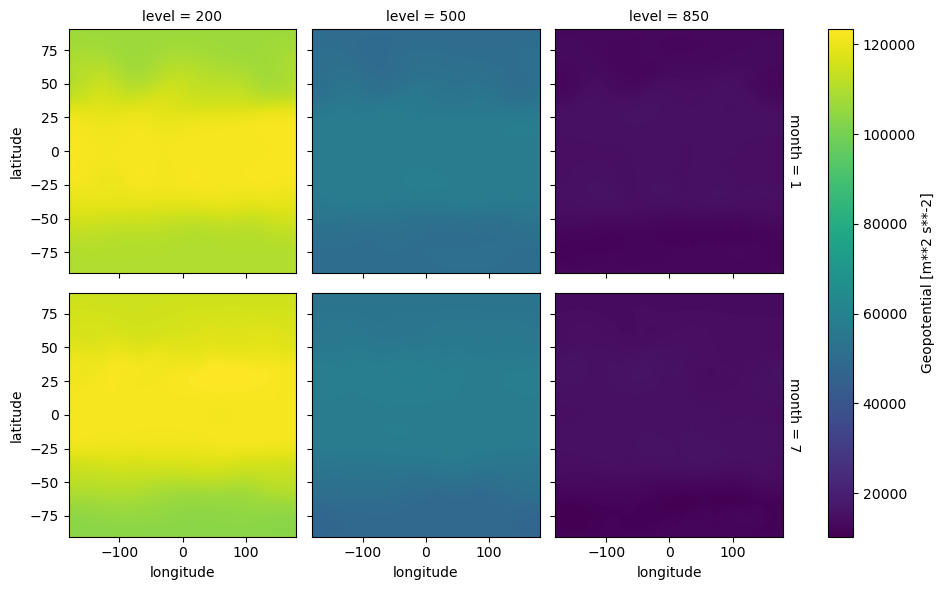

In [20]:
ds.z.plot(row='month', col='level')

This Dataset is indexed by longitude and latitude representing the spatial grid. When aggregating using ``ds.xvec.zonal_stats``, you are replacing these two dimensions with a single one with shapely geometry.

**Land mass geometry**

Read the file representing the generalized global land mass as a set of polygons.

In [11]:
world = gpd.read_file(geodatasets.get_path("naturalearth land"))
world.head()

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."


## Default aggregation

Using the `.xvec.zonal_stats` method with any array of geometries, like a ``geopandas.GeoSeries`` in this case, will create a `Dataset` (or a `DataArray` if the original object is a `DataArray`) indexed by the `GeometryIndex`:

In [12]:
aggregated = ds.xvec.zonal_stats(
    world.geometry, x_coords="longitude", y_coords="latitude"
)
aggregated

<xarray.Dataset> Size: 19kB
Dimensions:   (level: 3, month: 2, geometry: 127)
Coordinates:
  * level     (level) int32 12B 200 500 850
  * month     (month) int32 8B 1 7
  * geometry  (geometry) object 1kB POLYGON ((-59.57209469261153 -80.04017872...
Data variables:
    z         (geometry, month, level) float64 6kB 1.1e+05 ... 1.394e+04
    u         (geometry, month, level) float64 6kB 2.401 1.482 ... 2.393 0.8898
    v         (geometry, month, level) float64 6kB 0.4296 0.07286 ... 0.6399
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

Check the output visually.

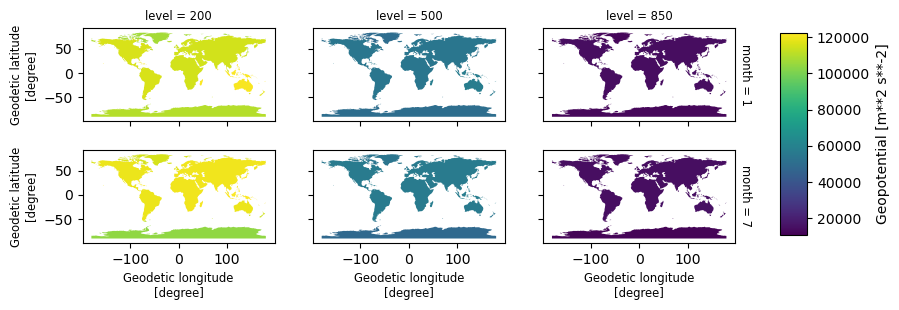

In [21]:
f, ax = aggregated.z.xvec.plot(row='month', col='level')

## Aggregation options

By default, the values are aggregated using `mean` but you have plenty of other options. For example, you may want to use `sum` instead.

In [5]:
aggregated_sum = ds.xvec.zonal_stats(
    world.geometry, x_coords="longitude", y_coords="latitude", stats="sum"
)
aggregated_sum

<xarray.Dataset>
Dimensions:   (level: 3, month: 2, geometry: 127)
Coordinates:
  * level     (level) int32 200 500 850
  * month     (month) int32 1 7
  * geometry  (geometry) object POLYGON ((-59.57209469261153 -80.040178725096...
Data variables:
    z         (geometry, month, level) float64 3.301e+05 1.507e+05 ... 1.675e+07
    u         (geometry, month, level) float64 7.203 4.446 ... 1.069e+03
    v         (geometry, month, level) float64 1.289 0.2186 ... 1.341e+03 768.5
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

Or pass a list of aggregations that will form another dimension of the resulting cube.

In [6]:
aggregated_multiple = ds.xvec.zonal_stats(
    world.geometry, x_coords="longitude", y_coords="latitude", stats=["mean", "sum"]
)
aggregated_multiple

<xarray.Dataset>
Dimensions:           (level: 3, month: 2, zonal_statistics: 2, geometry: 127)
Coordinates:
  * level             (level) int32 200 500 850
  * month             (month) int32 1 7
  * zonal_statistics  (zonal_statistics) <U4 'mean' 'sum'
  * geometry          (geometry) object POLYGON ((-59.57209469261153 -80.0401...
Data variables:
    z                 (geometry, zonal_statistics, month, level) float64 1.1e...
    u                 (geometry, zonal_statistics, month, level) float64 2.40...
    v                 (geometry, zonal_statistics, month, level) float64 0.42...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

Within the list, aggregations can be specified using a string representing an aggregation method available as `DataArray/Dataset` or `*GroupBy` methods like `DataArray.mean`, `DataArray.min` or `DataArray.max`. Alternatively, you can pass a callable accepted by `DataArray/Dataset.reduce`. Alternatively, you can pass a `tuple` in a format `(name, func)` where `name` is used as a coordinate and `func` is either known string as above or a callable, or `(name, func, {kwargs})`, if you need to pass additional keyword arguments.

In [7]:
aggregated_custom = ds.xvec.zonal_stats(
    world.geometry,
    x_coords="longitude",
    y_coords="latitude",
    stats=[
        "mean",
        "sum",
        ("quantile", "quantile", dict(q=[0.1, 0.2, 0.3])),
        ("numpymean", np.nanmean),
        np.nanstd,
    ],
)
aggregated_custom

<xarray.Dataset>
Dimensions:           (level: 3, month: 2, quantile: 3, zonal_statistics: 5,
                       geometry: 127)
Coordinates:
  * level             (level) int32 200 500 850
  * month             (month) int32 1 7
  * quantile          (quantile) float64 0.1 0.2 0.3
  * zonal_statistics  (zonal_statistics) <U9 'mean' 'sum' ... 'nanstd'
  * geometry          (geometry) object POLYGON ((-59.57209469261153 -80.0401...
Data variables:
    z                 (geometry, zonal_statistics, month, level, quantile) float64 ...
    u                 (geometry, zonal_statistics, month, level, quantile) float64 ...
    v                 (geometry, zonal_statistics, month, level, quantile) float64 ...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

## Other options

You have also other options of customizing the results. You may want to use a different name for the dimension indexed by geometry by passing a `name`, save the index of the original `GeoSeries` alongside the geometries with `index=True` (index is preserved automatically if it is non-default) or define which pixels are consider being a part of a geometry using `all_touched=True`. If True, all pixels touched by geometries will be considered. If False, only pixels whose center is within the polygon or that are selected by Bresenham’s line algorithm will be considered.

In [8]:
aggregated = ds.xvec.zonal_stats(
    world.geometry,
    x_coords="longitude",
    y_coords="latitude",
    name="world_polygons",
    index=True,
    all_touched=True,
)
aggregated

<xarray.Dataset>
Dimensions:         (level: 3, world_polygons: 127, month: 2)
Coordinates:
  * level           (level) int32 200 500 850
  * month           (month) int32 1 7
  * world_polygons  (world_polygons) object POLYGON ((-59.57209469261153 -80....
    index           (world_polygons) int64 0 1 2 3 4 5 ... 122 123 124 125 126
Data variables:
    z               (world_polygons, month, level) float64 1.1e+05 ... 1.393e+04
    u               (world_polygons, month, level) float64 2.345 ... 0.8456
    v               (world_polygons, month, level) float64 0.4407 ... 0.5869
Indexes:
    world_polygons  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

## Rasterization methods

Xvec currently offers two methods used to rasterize the geometry. Both are implemented using `rasterio` but the default method (`rasterize`) creates a single categorical array based on input geometries using `rasterio.features.rasterize`. This is a very performant option but comes with a set of limitations. Each pixel can be allocated to a single geometry only, meaning that the aggregation for overlapping geometries will not be precise. Furhtermore, in situations when you have small polygons compared
to pixels, some polygons may not be represented in the categorical array and resulting statistics on them will be `nan`.

Another option is to use `method="iterate"`, which is using iteration over `rasterio.features.geometry_mask`. This method is significantly less performant even though it is by default executed in parallel (number of threads can be controlled by `n_jobs` where `-1` represents all available cores). On the other hand, it does not have the limitations of exclusivity as the `rasterize` method and can be more memory efficient.

In [9]:
aggregated_iterative = ds.xvec.zonal_stats(
    world.geometry,
    x_coords="longitude",
    y_coords="latitude",
    method="iterate",
    n_jobs=-1,
)
aggregated_iterative

<xarray.Dataset>
Dimensions:   (geometry: 127, month: 2, level: 3)
Coordinates:
  * level     (level) int32 200 500 850
  * month     (month) int32 1 7
  * geometry  (geometry) object POLYGON ((-59.57209469261153 -80.040178725096...
Data variables:
    z         (geometry, month, level) float64 1.1e+05 5.025e+04 ... 1.394e+04
    u         (geometry, month, level) float64 2.401 1.482 ... 2.393 0.8898
    v         (geometry, month, level) float64 0.4296 0.07286 ... 1.116 0.6399
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

Another option is to use `method="exactextract"`, which is using `exactextract.exact_extract`. It provides a fast and accurate statistcs by determining the fraction of each pixel that is covered by the polygon. On the other hand, the aggregation options limited to be string or list of strings (e.g., `"mean"`,`"sum"`), the quantile option should be in this pattern `quantile(q=0.20)`.

In [4]:
aggregated_iterative = ds.xvec.zonal_stats(
    world.geometry,
    x_coords="longitude",
    y_coords="latitude",
    method="exactextract",
)
aggregated_iterative

<xarray.Dataset> Size: 19kB
Dimensions:   (geometry: 127, month: 2, level: 3)
Coordinates:
  * geometry  (geometry) object 1kB POLYGON ((-59.57209469261153 -80.04017872...
  * month     (month) int32 8B 1 7
  * level     (level) int32 12B 200 500 850
Data variables:
    z         (geometry, month, level) float64 6kB 1.1e+05 ... 1.394e+04
    u         (geometry, month, level) float64 6kB 2.342 1.357 ... 2.395 0.8823
    v         (geometry, month, level) float64 6kB 0.4431 0.211 ... 1.116 0.6409
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

## Zonal statistics using variable geometry

If you have shapely geometry stored as a variable geometry in the data cube, you can directly use it as an input for the zonal statistics, which will then preserve the dimensionality of the input and returns aligned Dataset. In this case, xvec automatically uses iterative method.

Take a subset of Svalbard glaciers and an extract of Sentinel 2 covering the same area.

In [3]:
sentinel_2 = rioxarray.open_rasterio('svalbard.tiff')

glaciers_df = gpd.read_file("https://github.com/loreabad6/post/raw/refs/heads/main/inst/extdata/svalbard.gpkg").to_crs(sentinel_2.rio.crs)
glaciers = (
    glaciers_df.set_index(["year", "name"])
    .to_xarray()
    .proj.assign_crs(spatial_ref=glaciers_df.crs)  # use xproj to store the CRS information
)

The method just picks up the input and automatically adapts the structure of the output to be aligned with the input geometry.

In [4]:
aggregated_variable = sentinel_2.xvec.zonal_stats(glaciers.geometry, x_coords='x', y_coords="y", stats=['mean', 'std'])
aggregated_variable

<xarray.Dataset> Size: 2kB
Dimensions:           (year: 3, name: 5, zonal_statistics: 2, band: 11)
Coordinates:
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * band              (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
    spatial_ref       int64 8B 0
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
Data variables:
    statistics        (year, name, zonal_statistics, band) float32 1kB 2.52e+...

You can merge it together to a single Dataset.

In [5]:
merged = xr.merge([glaciers, aggregated_variable])
merged

<xarray.Dataset> Size: 2kB
Dimensions:           (year: 3, name: 5, zonal_statistics: 2, band: 11)
Coordinates:
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * spatial_ref       int64 8B 0
  * band              (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
Data variables:
    length            (year, name) float64 120B 5.808e+03 ... 1.819e+03
    fwidth            (year, name) float64 120B 1.254e+03 1.216e+03 ... 202.6
    geometry          (year, name) object 120B POLYGON ((11.849495608926878 7...
    statistics        (year, name, zonal_statistics, band) float32 1kB 2.52e+...
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:4326)

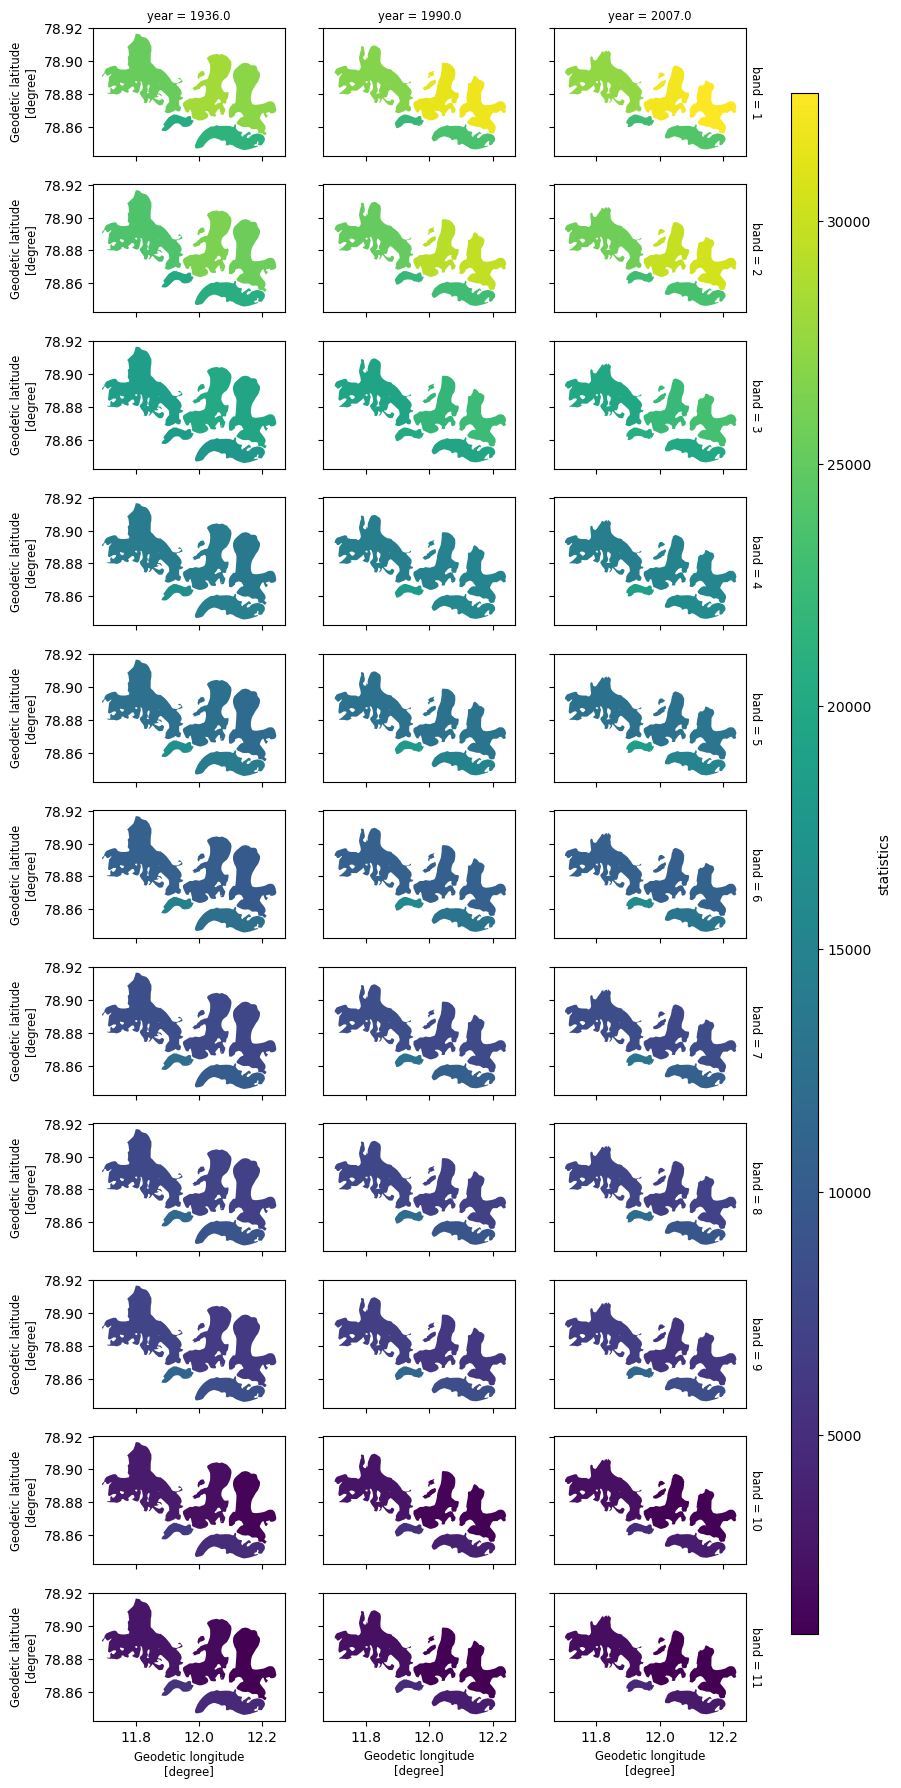

In [8]:
f, ax = merged.sel(zonal_statistics='mean').xvec.plot(geometry="geometry", row="band", col="year", hue="statistics")

## Comparison with other methods

A main difference compared to other methods available in the ecosystem is the resulting object being a vector data cube, preserving the original dimensionality of an Xarray object.

### geocube

[Geocube's method](https://corteva.github.io/geocube/stable/examples/zonal_statistics.html) for zonal statistics using `make_geocube` is in principle very similar to the implemenation using `method="rasterize"`. Xvec's method is a bit more generic and does not require a rioxarray CRS attached to the object but requires a user to ensure that the data are using the same projection. The same zonal statistics from geocube documentation can be done using a single line of code.

Load the data:

In [10]:
ssurgo_data = gpd.read_file(
    "https://raw.githubusercontent.com/corteva/geocube/master/test/test_data/input/soil_data_group.geojson"
)
ssurgo_data = ssurgo_data.loc[ssurgo_data.hzdept_r == 0]

elevation = (
    rioxarray.open_rasterio(
        "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n42w091/USGS_13_n42w091.tif",
        masked=True,
    )
    .rio.clip(ssurgo_data.geometry.values, ssurgo_data.crs, from_disk=True)
    .sel(band=1)
    .drop_vars("band")
)
elevation.name = "elevation"

Generate zonal statistics.

In [11]:
zonal_stats = elevation.xvec.zonal_stats(
    ssurgo_data.to_crs(elevation.rio.crs).geometry,  # ensure the correct CRS
    "x",
    "y",
    stats=["mean", "min", "max", "std"],
)
zonal_stats

<xarray.DataArray 'elevation' (geometry: 7, zonal_statistics: 4)>
array([[1.69547634e+02, 1.69539307e+02, 1.69804550e+02, 3.65312762e-02],
       [1.73920127e+02, 1.69558762e+02, 1.89282532e+02, 4.23546672e+00],
       [1.71910405e+02, 1.67691681e+02, 1.86318939e+02, 3.20585141e+00],
       [1.76756619e+02, 1.70410980e+02, 1.80344055e+02, 2.74917394e+00],
       [1.74971541e+02, 1.70244766e+02, 1.79659058e+02, 2.09304460e+00],
       [1.76334406e+02, 1.69263535e+02, 1.94975769e+02, 3.93324959e+00],
       [1.80006464e+02, 1.78314453e+02, 1.81538788e+02, 6.22535698e-01]])
Coordinates:
    spatial_ref       int64 0
  * zonal_statistics  (zonal_statistics) <U4 'mean' 'min' 'max' 'std'
  * geometry          (geometry) object MULTIPOLYGON (((-90.59735248065536 41...
    index             (geometry) int64 0 11 22 33 44 55 66
Indexes:
    geometry  GeometryIndex (crs=EPSG:4269)
Attributes:
    AREA_OR_POINT:          Area
    BandDefinitionKeyword:  *
    DataType:               *
    LAYER_TYPE:             athematic
    RepresentationType:     *
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              Layer_1

### rasterstats.zonal_stats

[Rasterstats' implementation](https://pythonhosted.org/rasterstats/manual.html#zonal-statistics), on the other hand, is similar to `method="iterate"` and should have a similar performance as both depend on the same `rasterio` functionality. The main difference is that Xvec assumes raster data to be an Xarray object and geometries being shapely objects.

### xarray-spatial

The [zonal statistics](https://xarray-spatial.org/user_guide/zonal.html) available in `xarray-spatial` does not depend on GDAL unlike any of the previous options but uses Datashader's aggregate instead.